# Traveler Behavior Segmentation Pipeline

This notebook builds a clean, reproducible, user-level traveler segmentation pipeline with three stages:
1. PCA + KMeans
2. Autoencoder + KMeans
3. Denoising Autoencoder + KMeans

It is designed to avoid column mismatch errors by normalizing Expedia-style raw columns into a canonical schema.


In [35]:
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cpu


In [36]:
# Configuration
DATA_PATH = r"c:/Users/karti/Downloads/travel (1).csv"
MIN_EVENTS = 3
N_CLUSTERS = 4

STAY_LENGTH_CLIP = (1, 30)
DAYS_TO_CHECKIN_CLIP = (0, 365)

FEATURE_COLS = [
    "total_search_events", "total_bookings", "booking_rate", "avg_distance",
    "mobile_ratio", "package_ratio", "avg_adults", "avg_children", "avg_rooms",
    "avg_stay_length", "avg_days_to_checkin", "family_traveler", "solo_traveler"
]


## Helper Functions
- `load_and_normalize`: schema-safe canonicalization
- `clean_and_clip`: clipping and missing-value handling
- `build_user_features`: user-level aggregation
- Autoencoder training and clustering utilities


In [37]:
def load_and_normalize(df_raw: pd.DataFrame) -> pd.DataFrame:
    df = df_raw.copy()

    rename_map = {
        "orig_destination_distance": "distance",
        "srch_adults_cnt": "adults",
        "srch_children_cnt": "children",
        "srch_rm_cnt": "rooms",
    }
    existing_renames = {k: v for k, v in rename_map.items() if k in df.columns}
    df = df.rename(columns=existing_renames)

    for col in ["date_time", "srch_ci", "srch_co"]:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")

    if "stay_length" not in df.columns:
        if {"srch_ci", "srch_co"}.issubset(df.columns):
            df["stay_length"] = (df["srch_co"] - df["srch_ci"]).dt.days

    if "days_to_checkin" not in df.columns:
        if {"date_time", "srch_ci"}.issubset(df.columns):
            df["days_to_checkin"] = (df["srch_ci"] - df["date_time"]).dt.days

    required = [
        "user_id", "is_booking", "is_mobile", "is_package", "distance",
        "adults", "children", "rooms", "stay_length", "days_to_checkin"
    ]

    missing_required = [c for c in required if c not in df.columns]
    if missing_required:
        raise ValueError(f"Missing required canonical columns: {missing_required}")

    keep_cols = required + [c for c in ["date_time", "srch_ci", "srch_co"] if c in df.columns]
    df = df[keep_cols].copy()

    numeric_cols = [
        "user_id", "is_booking", "is_mobile", "is_package", "distance",
        "adults", "children", "rooms", "stay_length", "days_to_checkin"
    ]
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    print("Normalized columns:")
    print(df.columns.tolist())
    print("Null summary:")
    print(df.isna().sum().sort_values(ascending=False))

    return df


def clean_and_clip(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    out["stay_length"] = out["stay_length"].clip(*STAY_LENGTH_CLIP)
    out["days_to_checkin"] = out["days_to_checkin"].clip(*DAYS_TO_CHECKIN_CLIP)

    out.loc[out["distance"] < 0, "distance"] = np.nan

    binary_cols = ["is_mobile", "is_package", "is_booking"]
    behavior_numeric_cols = [
        "distance", "adults", "children", "rooms", "stay_length", "days_to_checkin"
    ]

    for col in behavior_numeric_cols:
        med = out[col].median()
        out[col] = out[col].fillna(med)

    for col in binary_cols:
        out[col] = pd.to_numeric(out[col], errors="coerce").fillna(0)

    return out


def build_user_features(df: pd.DataFrame) -> pd.DataFrame:
    grouped = df.groupby("user_id", as_index=False).agg(
        total_search_events=("user_id", "size"),
        total_bookings=("is_booking", "sum"),
        avg_distance=("distance", "mean"),
        mobile_ratio=("is_mobile", "mean"),
        package_ratio=("is_package", "mean"),
        avg_adults=("adults", "mean"),
        avg_children=("children", "mean"),
        avg_rooms=("rooms", "mean"),
        avg_stay_length=("stay_length", "mean"),
        avg_days_to_checkin=("days_to_checkin", "mean"),
    )

    grouped["booking_rate"] = grouped["total_bookings"] / grouped["total_search_events"]
    grouped["family_traveler"] = (grouped["avg_children"] > 0).astype(int)
    grouped["solo_traveler"] = (
        (grouped["avg_adults"] <= 1)
        & (grouped["avg_children"] == 0)
        & (grouped["avg_rooms"] <= 1)
    ).astype(int)

    grouped = grouped[grouped["total_search_events"] >= MIN_EVENTS].reset_index(drop=True)
    return grouped


class Autoencoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int, use_batchnorm: bool = False):
        super().__init__()

        def block(in_dim, out_dim, bn=False):
            layers = [nn.Linear(in_dim, out_dim)]
            if bn:
                layers.append(nn.BatchNorm1d(out_dim))
            layers.append(nn.ReLU())
            return layers

        self.encoder = nn.Sequential(
            *block(input_dim, 32, bn=use_batchnorm),
            *block(32, 16, bn=use_batchnorm),
            nn.Linear(16, latent_dim),
        )

        self.decoder = nn.Sequential(
            *block(latent_dim, 16, bn=use_batchnorm),
            *block(16, 32, bn=use_batchnorm),
            nn.Linear(32, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat


def train_autoencoder(
    X_scaled: np.ndarray,
    latent_dim: int,
    denoising: bool = False,
    noise_std: float = 0.0,
    use_batchnorm: bool = False,
    weight_decay: float = 0.0,
    epochs: int = 100,
    batch_size: int = 256,
    lr: float = 1e-3,
):
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)

    model = Autoencoder(
        input_dim=X_scaled.shape[1],
        latent_dim=latent_dim,
        use_batchnorm=use_batchnorm,
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for (x_batch,) in loader:
            x_batch = x_batch.to(device)
            if denoising:
                x_in = x_batch + torch.randn_like(x_batch) * noise_std
            else:
                x_in = x_batch

            x_hat = model(x_in)
            loss = criterion(x_hat, x_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * x_batch.size(0)

        if (epoch + 1) % 20 == 0 or epoch == 0:
            avg_loss = epoch_loss / len(dataset)
            print(f"Epoch {epoch+1:03d}/{epochs} | Loss: {avg_loss:.6f}")

    model.eval()
    with torch.no_grad():
        z = model.encoder(X_tensor.to(device)).cpu().numpy()

    return model, z


def run_kmeans_and_score(Z: np.ndarray, n_clusters: int = 4, seed: int = 42):
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init=20)
    labels = kmeans.fit_predict(Z)
    score = silhouette_score(Z, labels)
    return labels, score


def plot_clusters_2d(points2d: np.ndarray, labels: np.ndarray, title: str) -> None:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=points2d[:, 0],
        y=points2d[:, 1],
        hue=labels,
        palette="tab10",
        s=35,
        alpha=0.9,
        linewidth=0,
    )
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


## Load, Normalize, Clean, and Build User Features


In [38]:
df_raw = pd.read_csv(DATA_PATH)
print(f"Raw shape: {df_raw.shape}")

# Remove accidental index column if present.
if "Unnamed: 0" in df_raw.columns:
    df_raw = df_raw.drop(columns=["Unnamed: 0"])

df_norm = load_and_normalize(df_raw)
df_clean = clean_and_clip(df_norm)

user_df = build_user_features(df_clean)
print(f"User-level shape after filter total_search_events >= {MIN_EVENTS}: {user_df.shape}")

X = user_df[FEATURE_COLS].copy()
assert X.columns.tolist() == FEATURE_COLS, "Feature columns mismatch before scaling."

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature matrix shape:", X.shape)
X.head()


Raw shape: (100000, 25)
Normalized columns:
['user_id', 'is_booking', 'is_mobile', 'is_package', 'distance', 'adults', 'children', 'rooms', 'stay_length', 'days_to_checkin', 'date_time', 'srch_ci', 'srch_co']
Null summary:
distance           36085
days_to_checkin      122
srch_ci              122
srch_co              122
stay_length          122
is_package             0
is_mobile              0
is_booking             0
user_id                0
rooms                  0
children               0
adults                 0
date_time              0
dtype: int64
User-level shape after filter total_search_events >= 3: (1251, 14)
Feature matrix shape: (1251, 13)


,total_search_events,total_bookings,booking_rate,avg_distance,mobile_ratio,package_ratio,avg_adults,avg_children,avg_rooms,avg_stay_length,avg_days_to_checkin,family_traveler,solo_traveler
0,3,0,0.0,1131.835300,1.00,0.000000,2.0,1.000000,1.0,4.000000,84.333333,1,0
1,4,0,0.0,2044.273925,0.25,0.500000,2.0,0.750000,1.5,2.000000,8.500000,1,0
2,3,0,0.0,1131.835300,0.00,0.333333,1.0,0.000000,1.0,1.333333,41.333333,0,1
3,3,0,0.0,1131.835300,0.00,0.333333,2.0,0.333333,1.0,3.000000,55.666667,1,0
4,5,3,0.6,1417.029260,0.00,0.000000,1.8,0.000000,1.0,1.600000,14.000000,0,0


## Stage 1: PCA (90% variance) + KMeans (k=4)


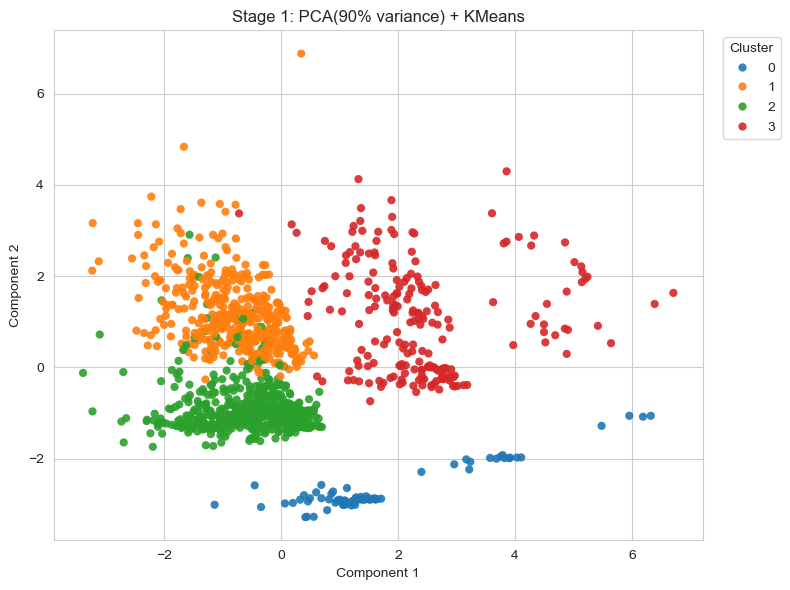

Stage 1 silhouette: 0.2059
Stage 1 representation dimension: 10


In [39]:
pca_stage1 = PCA(n_components=0.90, random_state=SEED)
X_pca = pca_stage1.fit_transform(X_scaled)

labels1, sil1 = run_kmeans_and_score(X_pca, n_clusters=N_CLUSTERS, seed=SEED)

# 2D visualization (separate PCA for plotting)
pca_vis = PCA(n_components=2, random_state=SEED)
X_vis_stage1 = pca_vis.fit_transform(X_scaled)
plot_clusters_2d(X_vis_stage1, labels1, "Stage 1: PCA(90% variance) + KMeans")

print(f"Stage 1 silhouette: {sil1:.4f}")
print(f"Stage 1 representation dimension: {X_pca.shape[1]}")
assert X_pca.shape[1] >= 2, "Stage 1 PCA representation has fewer than 2 dimensions."


## Stage 2: Basic Autoencoder (latent=5) + KMeans


Epoch 001/100 | Loss: 1.008970
Epoch 020/100 | Loss: 0.677698
Epoch 040/100 | Loss: 0.398163
Epoch 060/100 | Loss: 0.315561
Epoch 080/100 | Loss: 0.264237
Epoch 100/100 | Loss: 0.216158


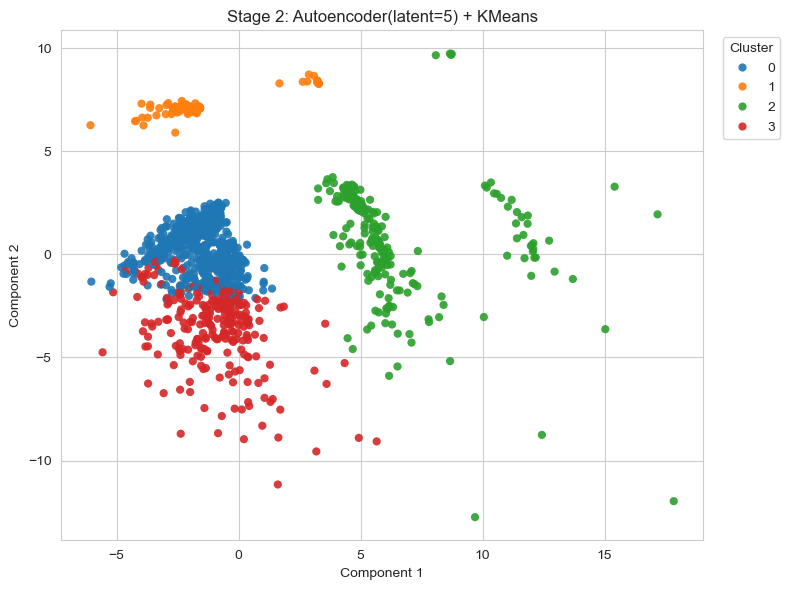

Stage 2 silhouette: 0.3762
Stage 2 latent dimension: 5


In [40]:
ae_model, Z2 = train_autoencoder(
    X_scaled=X_scaled,
    latent_dim=5,
    denoising=False,
    noise_std=0.0,
    use_batchnorm=False,
    weight_decay=0.0,
    epochs=100,
    batch_size=256,
    lr=1e-3,
)

labels2, sil2 = run_kmeans_and_score(Z2, n_clusters=N_CLUSTERS, seed=SEED)

# 2D latent visualization via PCA
Z2_vis = PCA(n_components=2, random_state=SEED).fit_transform(Z2)
plot_clusters_2d(Z2_vis, labels2, "Stage 2: Autoencoder(latent=5) + KMeans")

print(f"Stage 2 silhouette: {sil2:.4f}")
print(f"Stage 2 latent dimension: {Z2.shape[1]}")
assert Z2.shape[1] == 5, "Stage 2 latent dimension is not 5."


## Stage 3: Denoising Autoencoder (latent=3, BatchNorm, noise, weight decay) + KMeans


Epoch 001/140 | Loss: 1.195690
Epoch 020/140 | Loss: 0.600418
Epoch 040/140 | Loss: 0.428053
Epoch 060/140 | Loss: 0.373221
Epoch 080/140 | Loss: 0.342249
Epoch 100/140 | Loss: 0.318962
Epoch 120/140 | Loss: 0.296202
Epoch 140/140 | Loss: 0.294134


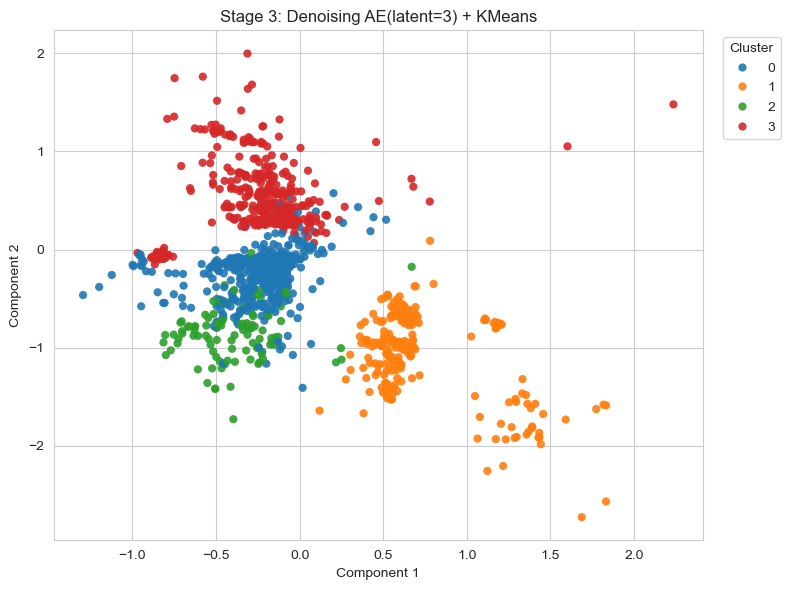

Stage 3 silhouette: 0.4467
Stage 3 latent dimension: 3


In [41]:
dae_model, Z3 = train_autoencoder(
    X_scaled=X_scaled,
    latent_dim=3,
    denoising=True,
    noise_std=0.1,
    use_batchnorm=True,
    weight_decay=1e-5,
    epochs=140,
    batch_size=256,
    lr=1e-3,
)

kmeans3 = KMeans(n_clusters=N_CLUSTERS, random_state=SEED, n_init=20)
labels3 = kmeans3.fit_predict(Z3)
sil3 = silhouette_score(Z3, labels3)

# 2D plot directly from first two latent dimensions
plot_clusters_2d(Z3[:, :2], labels3, "Stage 3: Denoising AE(latent=3) + KMeans")

user_df["final_cluster"] = labels3

print(f"Stage 3 silhouette: {sil3:.4f}")
print(f"Stage 3 latent dimension: {Z3.shape[1]}")
assert Z3.shape[1] == 3, "Stage 3 latent dimension is not 3."


## Comparison Table and Final Outputs


In [42]:
comparison_df = pd.DataFrame(
    {
        "stage": ["Stage 1: PCA + KMeans", "Stage 2: AE + KMeans", "Stage 3: Denoising AE + KMeans"],
        "representation_dim": [X_pca.shape[1], Z2.shape[1], Z3.shape[1]],
        "silhouette_score": [sil1, sil2, sil3],
    }
).sort_values("silhouette_score", ascending=False).reset_index(drop=True)

print("Silhouette Scores")
print(f"Stage 1 silhouette: {sil1:.4f}")
print(f"Stage 2 silhouette: {sil2:.4f}")
print(f"Stage 3 silhouette: {sil3:.4f}")
print("Model Comparison")
display(comparison_df)

# Final cluster profile
cluster_profile = (
    user_df.groupby("final_cluster")[FEATURE_COLS]
    .mean()
    .round(3)
)
cluster_counts = user_df["final_cluster"].value_counts().sort_index().rename("user_count")
cluster_profile = cluster_profile.join(cluster_counts)

print("Final Cluster Profile (Stage 3 clusters)")
display(cluster_profile)

print("Sample final clustered users")
display(user_df.head(10))


Silhouette Scores
Stage 1 silhouette: 0.2059
Stage 2 silhouette: 0.3762
Stage 3 silhouette: 0.4467
Model Comparison


,stage,representation_dim,silhouette_score
0,Stage 3: Denoising AE + KMeans,3,0.446738
1,Stage 2: AE + KMeans,5,0.376198
2,Stage 1: PCA + KMeans,10,0.205895


Final Cluster Profile (Stage 3 clusters)


,total_search_events,total_bookings,booking_rate,avg_distance,mobile_ratio,package_ratio,avg_adults,avg_children,avg_rooms,avg_stay_length,avg_days_to_checkin,family_traveler,solo_traveler,user_count
final_cluster,,,,,,,,,,,,,,
0,3.183,0.000,0.000,1913.634,0.027,0.253,2.061,0.025,1.108,3.559,60.782,0.060,0.036,553
1,3.250,1.165,0.364,1852.589,0.077,0.114,1.888,0.369,1.131,2.948,44.026,0.469,0.080,224
2,3.135,0.038,0.013,1927.262,0.848,0.300,2.096,0.339,1.075,3.861,59.351,0.365,0.010,104
3,3.111,0.000,0.000,1645.896,0.026,0.178,2.014,0.848,1.171,3.451,57.868,0.897,0.092,370


Sample final clustered users


,user_id,total_search_events,total_bookings,avg_distance,mobile_ratio,package_ratio,avg_adults,avg_children,avg_rooms,avg_stay_length,avg_days_to_checkin,booking_rate,family_traveler,solo_traveler,final_cluster
0,1751,3,0,1131.835300,1.00,0.000000,2.000000,1.000000,1.000000,4.000000,84.333333,0.000000,1,0,2
1,1923,4,0,2044.273925,0.25,0.500000,2.000000,0.750000,1.500000,2.000000,8.500000,0.000000,1,0,3
2,2249,3,0,1131.835300,0.00,0.333333,1.000000,0.000000,1.000000,1.333333,41.333333,0.000000,0,1,3
3,2916,3,0,1131.835300,0.00,0.333333,2.000000,0.333333,1.000000,3.000000,55.666667,0.000000,1,0,3
4,2956,5,3,1417.029260,0.00,0.000000,1.800000,0.000000,1.000000,1.600000,14.000000,0.600000,0,0,1
5,3594,3,1,1131.835300,0.00,0.000000,1.000000,0.000000,1.000000,7.000000,12.666667,0.333333,0,1,1
6,3839,3,0,1131.835300,0.00,0.000000,2.000000,0.333333,1.000000,1.000000,105.333333,0.000000,1,0,3
7,4116,3,0,1131.835300,0.00,0.666667,1.666667,0.000000,1.000000,4.666667,102.000000,0.000000,0,0,0
8,5927,3,0,982.186533,0.00,0.000000,2.000000,0.333333,1.333333,2.000000,63.000000,0.000000,1,0,3
9,6014,3,0,1131.835300,0.00,0.333333,1.000000,0.000000,1.000000,2.666667,15.000000,0.000000,0,1,3


## Validation Checks


In [43]:
# 1) Filtering rule validation
assert (user_df["total_search_events"] >= MIN_EVENTS).all(), "Found user with < 3 search events."

# 2) No leakage checks
for forbidden in ["user_id", "hotel_continent", "hotel_country", "hotel_market", "hotel_cluster"]:
    assert forbidden not in X.columns, f"Leakage: {forbidden} present in clustering features."

# 3) Silhouette score validity
for s in [sil1, sil2, sil3]:
    assert np.isfinite(s) and -1.0 <= s <= 1.0, "Invalid silhouette score."

# 4) Final output checks
assert "final_cluster" in user_df.columns, "final_cluster column missing."
unique_clusters = user_df["final_cluster"].nunique()
print(f"Unique final clusters: {unique_clusters}")
if unique_clusters != N_CLUSTERS:
    print("Warning: fewer than 4 clusters formed (possible data degeneracy).")

print("All validation checks passed.")


Unique final clusters: 4
All validation checks passed.


# Cluster Naming and Full-Population Labeling

This section names Stage-3 clusters and labels all users (including users with fewer than 3 events) using the trained scaler + denoising encoder + KMeans model.


In [44]:
def assign_cluster_names(profile_df: pd.DataFrame) -> dict:
    """Auto-assign readable cluster names based on dominant behavior metrics."""
    names = {}
    for cid, row in profile_df.iterrows():
        tags = []
        if row.get("booking_rate", 0) >= profile_df["booking_rate"].quantile(0.75):
            tags.append("High-Booking")
        elif row.get("booking_rate", 0) <= profile_df["booking_rate"].quantile(0.25):
            tags.append("Low-Booking")

        if row.get("mobile_ratio", 0) >= profile_df["mobile_ratio"].quantile(0.75):
            tags.append("Mobile-First")
        if row.get("package_ratio", 0) >= profile_df["package_ratio"].quantile(0.75):
            tags.append("Package-Oriented")
        if row.get("family_traveler", 0) >= profile_df["family_traveler"].quantile(0.75):
            tags.append("Family")
        if row.get("solo_traveler", 0) >= profile_df["solo_traveler"].quantile(0.75):
            tags.append("Solo")

        if not tags:
            tags = ["Balanced"]

        names[cid] = " / ".join(tags)

    # Ensure uniqueness for readability
    seen = {}
    for cid, name in list(names.items()):
        seen[name] = seen.get(name, 0) + 1
        if seen[name] > 1:
            names[cid] = f"{name} #{seen[name]}"
    return names


def build_user_features_all(df: pd.DataFrame) -> pd.DataFrame:
    """Same aggregation as training, but without the >=3 events filter."""
    grouped = df.groupby("user_id", as_index=False).agg(
        total_search_events=("user_id", "size"),
        total_bookings=("is_booking", "sum"),
        avg_distance=("distance", "mean"),
        mobile_ratio=("is_mobile", "mean"),
        package_ratio=("is_package", "mean"),
        avg_adults=("adults", "mean"),
        avg_children=("children", "mean"),
        avg_rooms=("rooms", "mean"),
        avg_stay_length=("stay_length", "mean"),
        avg_days_to_checkin=("days_to_checkin", "mean"),
    )
    grouped["booking_rate"] = grouped["total_bookings"] / grouped["total_search_events"]
    grouped["family_traveler"] = (grouped["avg_children"] > 0).astype(int)
    grouped["solo_traveler"] = ((grouped["avg_adults"] <= 1) & (grouped["avg_children"] == 0) & (grouped["avg_rooms"] <= 1)).astype(int)
    return grouped


# 1) Name clusters from Stage-3 profile (training population)
cluster_name_map = assign_cluster_names(cluster_profile)
user_df["cluster_name"] = user_df["final_cluster"].map(cluster_name_map)

named_profile = cluster_profile.copy()
named_profile["cluster_name"] = [cluster_name_map[c] for c in named_profile.index]
named_profile = named_profile.reset_index().rename(columns={"index": "final_cluster"})
display(named_profile[["final_cluster", "cluster_name", "user_count", "booking_rate", "mobile_ratio", "package_ratio", "family_traveler", "solo_traveler"]])

# 2) Label all users (including <3 events) with trained Stage-3 model
all_user_df = build_user_features_all(df_clean)
X_all = all_user_df[FEATURE_COLS].copy()
assert X_all.columns.tolist() == FEATURE_COLS, "Feature mismatch while scoring all users."

X_all_scaled = scaler.transform(X_all)
dae_model.eval()
with torch.no_grad():
    Z_all = dae_model.encoder(torch.tensor(X_all_scaled, dtype=torch.float32, device=device)).cpu().numpy()

if "kmeans3" not in globals():
    if "Z3" not in globals():
        raise NameError("kmeans3 is missing and Z3 is unavailable. Run the Stage 3 cell first.")
    kmeans3 = KMeans(n_clusters=N_CLUSTERS, random_state=SEED, n_init=20)
    kmeans3.fit(Z3)

all_labels = kmeans3.predict(Z_all)
all_user_df["predicted_cluster"] = all_labels
all_user_df["cluster_name"] = all_user_df["predicted_cluster"].map(cluster_name_map)
all_user_df["seen_in_training"] = all_user_df["total_search_events"] >= MIN_EVENTS

print(f"Training users (>= {MIN_EVENTS} events): {int(all_user_df['seen_in_training'].sum())}")
print(f"Additional labeled users (< {MIN_EVENTS} events): {int((~all_user_df['seen_in_training']).sum())}")

summary_all = (
    all_user_df.groupby(["predicted_cluster", "cluster_name"], as_index=False)
    .agg(
        user_count=("user_id", "count"),
        pct_of_all=("user_id", lambda s: 100 * len(s) / len(all_user_df)),
        booking_rate=("booking_rate", "mean"),
        mobile_ratio=("mobile_ratio", "mean"),
        package_ratio=("package_ratio", "mean"),
    )
)
summary_all["pct_of_all"] = summary_all["pct_of_all"].round(2)
display(summary_all.sort_values("predicted_cluster"))

# Optional export
# all_user_df.to_csv("data/user_clusters_all_users.csv", index=False)
# user_df.to_csv("data/user_clusters_training_users.csv", index=False)


,final_cluster,cluster_name,user_count,booking_rate,mobile_ratio,package_ratio,family_traveler,solo_traveler
0,0,Low-Booking,553,0.000,0.027,0.253,0.060,0.036
1,1,High-Booking,224,0.364,0.077,0.114,0.469,0.080
2,2,Mobile-First / Package-Oriented,104,0.013,0.848,0.300,0.365,0.010
3,3,Low-Booking / Family / Solo,370,0.000,0.026,0.178,0.897,0.092


Training users (>= 3 events): 1251
Additional labeled users (< 3 events): 87612


,predicted_cluster,cluster_name,user_count,pct_of_all,booking_rate,mobile_ratio,package_ratio
0,0,Low-Booking,44856,50.48,0.000000,0.008754,0.276863
1,1,High-Booking,7881,8.87,0.911496,0.103815,0.133566
2,2,Mobile-First / Package-Oriented,10899,12.26,0.001682,0.987997,0.310915
3,3,Low-Booking / Family / Solo,25227,28.39,0.000040,0.003013,0.214882


## Additional Visual Diagnostics

Extra visual checks for model comparison and Stage-3 cluster interpretation.


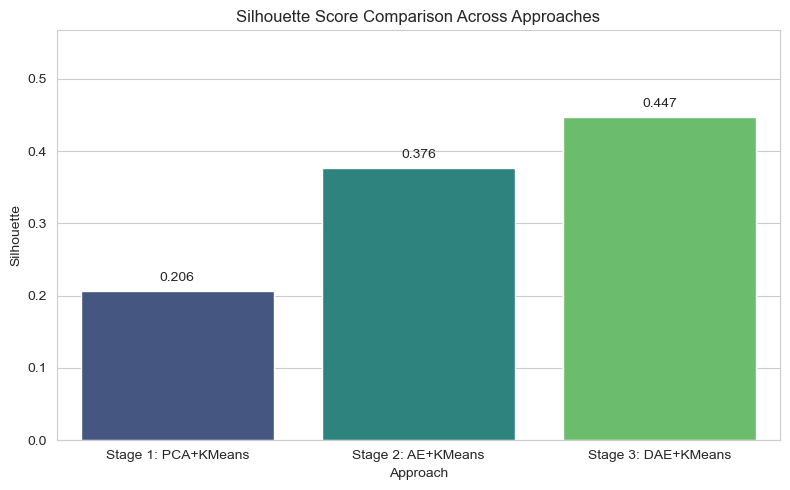

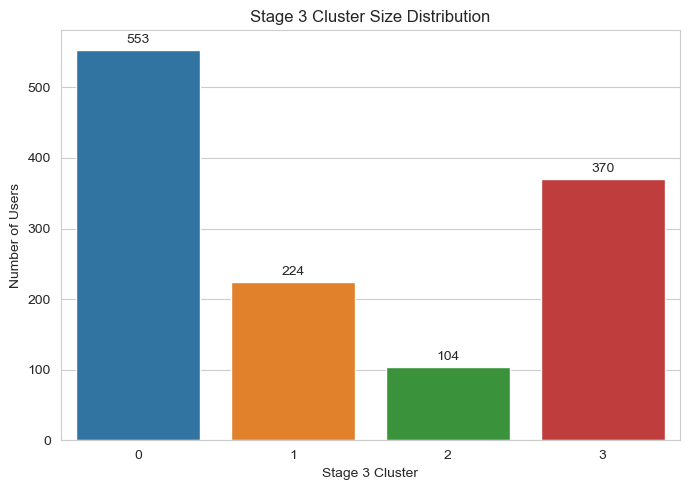

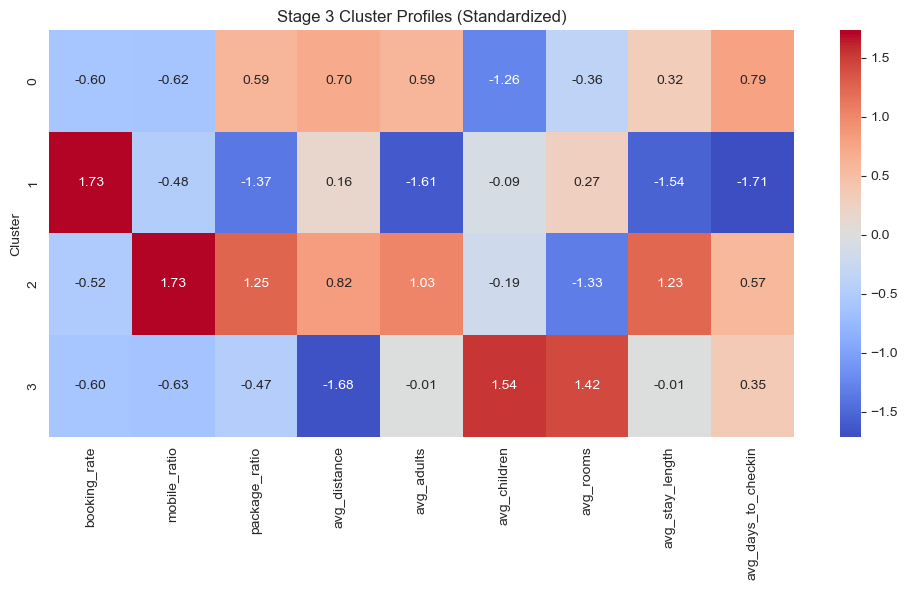

In [45]:
# 1) Compare silhouette scores across the 3 approaches
scores_df = pd.DataFrame({
    "Approach": ["Stage 1: PCA+KMeans", "Stage 2: AE+KMeans", "Stage 3: DAE+KMeans"],
    "Silhouette": [sil1, sil2, sil3],
})

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=scores_df, x="Approach", y="Silhouette", palette="viridis")
for i, v in enumerate(scores_df["Silhouette"]):
    ax.text(i, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=10)
plt.ylim(0, min(1.0, scores_df["Silhouette"].max() + 0.12))
plt.title("Silhouette Score Comparison Across Approaches")
plt.tight_layout()
plt.show()

# 2) Stage 3 cluster distribution (training users)
cluster_counts = user_df["final_cluster"].value_counts().sort_index()
plt.figure(figsize=(7, 5))
ax = sns.barplot(x=cluster_counts.index.astype(str), y=cluster_counts.values, palette="tab10")
for i, v in enumerate(cluster_counts.values):
    ax.text(i, v + max(cluster_counts.values) * 0.01, str(v), ha="center", va="bottom", fontsize=10)
plt.xlabel("Stage 3 Cluster")
plt.ylabel("Number of Users")
plt.title("Stage 3 Cluster Size Distribution")
plt.tight_layout()
plt.show()

# 3) Stage 3 cluster behavior heatmap (z-score across clusters)
heatmap_features = [
    "booking_rate", "mobile_ratio", "package_ratio", "avg_distance",
    "avg_adults", "avg_children", "avg_rooms",
    "avg_stay_length", "avg_days_to_checkin",
]
profile = user_df.groupby("final_cluster")[heatmap_features].mean()
profile_z = (profile - profile.mean()) / profile.std(ddof=0).replace(0, 1)

plt.figure(figsize=(10, 6))
sns.heatmap(profile_z, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Stage 3 Cluster Profiles (Standardized)")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()
